In [7]:
import pickle
import bson
import pandas as pd
from bson import ObjectId

In [9]:
#Cargamos los datos de los usuarios, y tomamos solo un trozo de los datos para no guardarlo todo.

filename = "usuarios.pickle"
usuarios = pd.read_pickle(filename)
usuarios = usuarios.iloc[range(0,20000),]
#Todos los ids de los usuarios de la muestra
idsMuestra = usuarios["_id"].to_list()

In [10]:
#Cargamos los datos de los tweets.
filename = "tweets.pickle"
tweets = pd.read_pickle(filename)

#Solo nos quedamos con las interacciones que se hayan realizado entre un par de 
#usuarios cuyos ids hayamos cogido antes.
tweets = tweets[tweets.user_id.isin(idsMuestra)
                & (tweets.in_reply_to_user_id.isin(idsMuestra) | 
                tweets.retweet_or_quote_user_id.isin(idsMuestra))]


In [6]:
usuarios.shape

(20000, 4)

In [7]:
tweets.shape

(58949, 6)

In [9]:
tweets.columns

Index(['created_at', 'in_reply_to_user_id', 'retweet_count',
       'retweet_or_quote_user_id', 'tweet_type', 'user_id'],
      dtype='object')

Si unimos los ids de ambas columnas podremos agrupar por los ids de los usuarios.

In [11]:
to_user_id = []

for index, row in tweets.iterrows():
    if row["in_reply_to_user_id"] == None:
        
        to_user_id.append(row["retweet_or_quote_user_id"])
        
    else:
        
        to_user_id.append(row["in_reply_to_user_id"])
        
tweets["to_user_id"] = to_user_id

In [12]:
#Agrupamos por todos los atributos necesarios para poder tner los datos de la forma que los buscamos
prueba = tweets.groupby(['user_id', 'to_user_id', 'tweet_type'])['to_user_id'].count().reset_index(name="count")

In [10]:
prueba.head(10)

,user_id,to_user_id,tweet_type,count
0,000000000000000000762481,000000000000000760278206,retweet,1
1,000000000000000000762481,000000000000002349006565,retweet,1
2,000000000000000000762481,000000922889265503195136,retweet,2
3,000000000000000002270621,000000000000000170338247,retweet,1
4,000000000000000002270621,000000000000000233928703,retweet,1
5,000000000000000002503051,000000000000000017484356,retweet,3
6,000000000000000002542931,000000000000000107153756,retweet,1
7,000000000000000003418691,000000000000003118989832,retweet,1
8,000000000000000003511961,000000000000000003511961,quote,1
9,000000000000000003511961,000000000000000003511961,reply,6


In [13]:
aliveUsers = []

for index, row in prueba.iterrows():
    
    if (row['user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['user_id'])
        
    if (row['to_user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['to_user_id'])

    
    
usuarios = usuarios[usuarios._id.isin(aliveUsers)]

In [14]:
#Machacamos ids muestra
idsMuestra = usuarios["_id"].to_list()

In [12]:
len(usuarios)

10600

In [29]:
len(prueba)

29879

A partir de aqui, empiezan a asociarse de forma que siguen la misma forma que las aristas que vamos a usar en el trabajo.

In [15]:
#Creamos un diccionario que relaciona todos los usuarios con todos los usuarios que alguna vez han creado contenido
#refiriendose a este, y asocia el número de cada tipo que ha realizado.
interacciones = {}

for index, row in prueba.iterrows():
    
    #Si son de tipo originales no los tenemos en cuenta.
    if row["tweet_type"] != "original":
    
        #Comprobamos si para este usuario hemos creado ya su hueco en el diccionario, si no se crea.
        if row["to_user_id"] in interacciones:
        
            if row["user_id"] in interacciones[row["to_user_id"]]:
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
        
            else:
                
                interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
                
        
        else:
        
            interacciones[row["to_user_id"]] = {}
            
            interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
            interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]

In [14]:
#Me parece bastante raro que hayan tan pocos usuarios a los que se dirigen de entre tantas interacciones que 
#se cogieron inicialmente

len(interacciones)

2950

In [16]:
#Una función que nos devuelva una lista como intersección de dos, haciendo uso de conjuntos:

def intersectionLists(list1, list2):  

    result = list(set(list1).intersection(list2))
    return result

In [17]:
#Utilizamos la función que consigue la intersección de dos conjuntos para quedarnos solo con los followers 
#de los usuarios que también están dentro de la muestra pequeña.
followers = {}

for index, row in usuarios.iterrows():
    
    followers[row["_id"]] = intersectionLists(idsMuestra, row["followers"])

In [18]:
#Vamos a guardar ambos diccionarios para luego poder cargarlos comodamente y no tener que generarlos otra vez.
#Para guardarlos vamos a usar también pickles.

import pickle

f = open("interacciones.pkl","wb")
pickle.dump(interacciones,f)
f.close()

f = open("idNodos.pkl","wb")
pickle.dump(idsMuestra,f)
f.close()

f = open("followers.pkl","wb")
pickle.dump(followers,f)
f.close()

In [19]:
#Ahora vamos a cargarlos. Ambos siguen siendo diccionarios, luego perfecto estaríamos igual que al principio.

filename = "interacciones.pkl"
interacciones = pd.read_pickle(filename)
filename = "idNodos.pkl"
idNodos = pd.read_pickle(filename)
filename = "followers.pkl"
followers = pd.read_pickle(filename)

Vamos a ver como se pueden transformar los object id a string para crear otro diccionario.

In [19]:
ejem = []
counter = 0

for item in followers:
    ejem.append(item)
    counter = counter + 1
    if counter == 2:
        break

In [20]:
ejem

[ObjectId('000000000000000272007797'), ObjectId('000000000000002310170998')]

In [25]:
a = str(ejem[0])
b = str(ejem[1])
ab = "("+a+","+b+")"
ab

'(000000000000000272007797,000000000000002310170998)'

In [26]:
#Aristas del grafo de foco, quitamos aristas dirigidas a si mismo
aristasGF = {}
beta = 0.7

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["reply"] > 0 or interacciones[user1][user2]["retweet"] > 0):
            if user1 != user2:
                arista = "("+str(user1)+","+str(user2)+")"
                aristasGF[arista] = beta *  interacciones[user1][user2]["retweet"] + (1-beta) * interacciones[user1][user2]["reply"]

In [23]:
len(aristasGF)

28366

In [24]:
#Con esto nos damos cuenta de que tenemos que usar todo el dataset
aristasGF

{'(000000000000000760278206,000000000000000000762481)': 0.7,
 '(000000000000000760278206,000000000000000010408022)': 0.7,
 '(000000000000000760278206,000000000000000025116518)': 0.7,
 '(000000000000000760278206,000000000000000107245463)': 0.7,
 '(000000000000000760278206,000000000000000150381815)': 0.7,
 '(000000000000000760278206,000000000000000153351097)': 0.7,
 '(000000000000000760278206,000000000000000194659332)': 0.7,
 '(000000000000000760278206,000000000000000200136153)': 0.30000000000000004,
 '(000000000000000760278206,000000000000000243891635)': 0.7,
 '(000000000000000760278206,000000000000000246000578)': 0.7,
 '(000000000000000760278206,000000000000000250712731)': 0.7,
 '(000000000000000760278206,000000000000000267257949)': 0.7,
 '(000000000000000760278206,000000000000000267661466)': 0.7,
 '(000000000000000760278206,000000000000000277729281)': 0.7,
 '(000000000000000760278206,000000000000000290182710)': 0.7,
 '(000000000000000760278206,000000000000000291605884)': 0.7,
 '(00000

In [27]:
#Aristas del grafo de autoridad

aristasGA = {}

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["quote"] > 0) and user1 != user2:
            
            arista = "("+str(user1)+","+str(user2)+")"
            aristasGA[arista] = interacciones[user1][user2]["quote"]

In [23]:
len(aristasGA)

223

In [ ]:
aristasGA

In [28]:
#Aristas del grafo de centralidad
aristasGC = {}
gamma = 0.6

for user1 in followers:
    
    for user2 in followers[user1]:
        arista = "("+str(user1)+","+str(user2)+")"
        aristasGC[arista] = gamma * len(followers[user1]) + (1 - gamma) * len(followers[user2])

In [25]:
len(aristasGC)

80494

In [ ]:
aristasGC

Una vez llegados a este punto ya tenemos todos las aristas y sus respectivos pesos para todos los nodos.
Vamos ahora a comenzar con la implementación del cálculo de pesos para cada nodo, que será diferente para los tres grafos, ya que dependerá de los pesos de las aristas.

In [26]:
#Vamos a realizar un paso previo y muy importante, este es relacionar cada nodo con sus aristas para cada grafo
#Cada nodo con las aristas que salen de el. De esta forma evitamos repetir el proceso muchas veces. 
#Las claves son los ids de los usuarios pero en string.

def nodoAristas(aristasGrafo):
    
    nodoAristas = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        nodoAristas[nodoid] = []
        for arista in aristasGrafo:
            
            if ("("+nodoid) in arista:
                
                nodoAristas[nodoid].append(arista)
                
    return nodoAristas

In [27]:
nodoAristasGF = nodoAristas(aristasGF)
nodoAristasGA = nodoAristas(aristasGA)
nodoAristasGC = nodoAristas(aristasGC)

In [28]:
#No necesitamos introducir nodos a la función ya que los tres grafos trabajan con el mismo conjunto.
def NIWT(aristasGrafo, alpha, nodoA): 
    
    NIWT = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        pesosAristas = 0
        
        for key in nodoA[nodoid]:
            
            pesosAristas = pesosAristas + aristasGrafo[key]
        
        NIWT[nodoid] = alpha * len(nodoA[nodoid]) + (1 - alpha) * pesosAristas

    return NIWT

In [29]:
#Tarda bastante, se debería poder hacer para que tardara menos aún. 
NIWTfoco = NIWT(aristasGF, 0.5, nodoAristasGF)

In [30]:
#Efectivamente tarda un huevo, aprox 5 min todo.
NIWTautoridad = NIWT(aristasGA, 0.5, nodoAristasGA)
NIWTcentralidad = NIWT(aristasGC, 0.5, nodoAristasGC)

In [31]:
def NPWT(aristasGrafo, alpha, niwt, nodoA):
    
    NPWT = {}
    for nodo1 in idNodos:
        
        nodo1id = str(nodo1)
        pesoGrafo = 0
        
        for nodo2 in idNodos:
            
            pesosAristas = 0
            nodo2id = str(nodo2)
            
            if nodo2 != nodo1:
                
                for arista in nodoA[nodo2id]:
                    
                    nodo3id = ((arista.split(","))[1])[:-1]
                    
                    pesosAristas = pesosAristas + aristasGrafo[arista] + niwt[nodo3id]
                
                pesoGrafo = pesoGrafo + alpha * len(nodoA[nodo2id]) + (1 - alpha) * pesosAristas
        
        NPWT[nodo1id] = pesoGrafo
    
    return NPWT  

In [32]:
NPWTfoco = NPWT(aristasGF, 0.5, NIWTfoco, nodoAristasGF)
NPWTautoridad = NPWT(aristasGA, 0.5, NIWTautoridad, nodoAristasGA)
NPWTcentralidad = NPWT(aristasGC, 0.5, NIWTcentralidad, nodoAristasGC)

In [33]:
#Vamos a guardar todos los diccionarios de puntuaciones para no tener que volver a cargarlos mas.

f = open("NPWTfoco.pkl","wb")
pickle.dump(NPWTfoco,f)
f.close()

f = open("NPWTautoridad.pkl","wb")
pickle.dump(NPWTautoridad,f)
f.close()

f = open("NPWTcentralidad.pkl","wb")
pickle.dump(NPWTcentralidad,f)
f.close()

In [3]:
#Ahora vamos a cargarlos.

filename = "NPWTfoco.pkl"
NPWTfoco = pd.read_pickle(filename)
filename = "NPWTautoridad.pkl"
NPWTautoridad = pd.read_pickle(filename)
filename = "NPWTcentralidad.pkl"
NPWTcentralidad = pd.read_pickle(filename)

In [15]:
NPWTfoco

{'000000000000000272007797': 136467.70000000275,
 '000000000000000269322187': 136447.75000000276,
 '000000000000001606763474': 136474.07500000275,
 '000000000000000265953469': 136470.25000000276,
 '000000000000000565074093': 136472.37500000274,
 '000001070017872292970496': 136368.57500000272,
 '000001033108791406088197': 136467.27500000276,
 '000001005536191540813826': 136474.07500000275,
 '000000000000000864620298': 136343.70000000272,
 '000000000000001598375022': 136474.07500000275,
 '000000000000002889758267': 136462.15000000276,
 '000000000000002634362381': 136474.07500000275,
 '000000000000000116724203': 136473.22500000274,
 '000000000000001238988487': 136474.07500000275,
 '000000973679485013852161': 136474.07500000275,
 '000000000000002584490118': 136474.07500000275,
 '000000000000000063947010': 136474.07500000275,
 '000000000000002236240423': 136474.07500000275,
 '000000000000002827029574': 136474.07500000275,
 '000000000000000534249741': 136474.07500000275,
 '000001147586336595

In [4]:
#Una vez tenemos los resultados de cada nodo podemos ordenarlos en capas.

def capas(NPWT):
    
    capas = {}
    
    for nodo in NPWT:
        
        if (NPWT[nodo] in capas):
            
            capas[NPWT[nodo]].append(nodo)
            
        else:
            
            capas[NPWT[nodo]] = [nodo]
            
    return capas

In [5]:
capasFoco = capas(NPWTfoco)
capasAutoridad = capas(NPWTautoridad)
capasCentralidad = capas(NPWTcentralidad)

In [6]:
ncf = len(capasFoco)
nca = len(capasAutoridad)
ncc = len(capasCentralidad)

In [7]:
ncf + nca + ncc

5012

In [8]:
#Faltaría ordenar el diccionario por el valor de sus key, y luego cambiar el nombre de las key por 1,2,3..
#lo que serían las capas respectivas. DESCENDENTE

#Para el grafo de foco
puntuaciones = list(capasFoco.keys())
puntuaciones.sort(reverse = True)

capasFocoOrd = {}
contador = 0

for key in puntuaciones:
    
    capasFocoOrd[contador] = capasFoco[key]
    contador = contador + 1

#Para el grafo de autoridad
puntuaciones = list(capasAutoridad.keys())
puntuaciones.sort(reverse = True)

capasAutoridadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasAutoridadOrd[contador] = capasAutoridad[key]
    contador = contador + 1

#Para el grafo de centralidad
puntuaciones = list(capasCentralidad.keys())
puntuaciones.sort(reverse = True)

capasCentralidadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasCentralidadOrd[contador] = capasCentralidad[key]
    contador = contador + 1

In [9]:
def userCapa(capasOrd):
    
    userCapa = {}
    
    for capa in capasOrd:
        for user in capasOrd[capa]:
            
            userCapa[user] = capa
    
    return userCapa

In [10]:
userCapaFoco = userCapa(capasFocoOrd)
userCapaAutoridad = userCapa(capasAutoridadOrd)
userCapaCentralidad = userCapa(capasCentralidadOrd)

In [11]:
len(userCapaFoco)

10600

In [12]:
import math

def TI(userCapa1, userCapa2, userCapa3, nc1, nc2, nc3):
    
    TI = {}
    
    numberUsers = len(userCapa1)
    digitos = len(str(numberUsers))
    h1 = digitos/2
    h = round(digitos/2)
    if h1 > h:
        h + 1
        
    for user in userCapa1:
        if (userCapa1[user] + userCapa2[user] + userCapa3[user]) != 0:
            TI[user] = ( (math.log(userCapa1[user] + userCapa2[user] + userCapa3[user])) / math.log(nc1 + nc2 + nc3) )**(h)
        else:
            TI[user] = 0
    
    return TI
    

In [13]:
TIFinal = TI(userCapaFoco, userCapaAutoridad, userCapaCentralidad, ncf, nca, ncc)

In [14]:
#Finalmente, con las puntuaciones conseguidas vamos a ordenarlos otra vez, lo que ya será la puntuación final.
TIFGrupos = {}

for user in TIFinal:
    
    if TIFinal[user] in TIFGrupos:
        TIFGrupos[TIFinal[user]].append(user)
    else:
        TIFGrupos[TIFinal[user]] = [user]

puntuaciones = list(TIFGrupos.keys())
puntuaciones.sort(reverse = True)

puntuacionesOrd = {}

for key in puntuaciones:
    
    puntuacionesOrd[key] = TIFGrupos[key]

In [104]:
puntuacionesOrd

{0.9993904052555804: ['000000000000000202372417'],
 0.9993434554199077: ['000000000000000107153756'],
 0.9991555731313075: ['000000933309177623121921'],
 0.9984969375237474: ['000000000000001361984828'],
 0.9983084557851927: ['000000000000000015133318'],
 0.9982141647680819: ['000000000000000125407623'],
 0.9980726654870213: ['000000000000000040900410', '000000000000000018097083'],
 0.9978838825035011: ['000000000000000200194757', '000000000000000301403189'],
 0.9977422071990613: ['000000000000000402219133'],
 0.9975531892087598: ['000000000000000331008858'],
 0.9975059136928999: ['000000000000002809058993'],
 0.9972694098455533: ['000000000000000022473944', '000000000000000093929450'],
 0.9969853270200372: ['000000000000003346916993'],
 0.9968905651900704: ['000000842106329347039232'],
 0.9967957695402069: ['000000000000000378525757'],
 0.9966060766785818: ['000000000000000243139600'],
 0.9964637180649328: ['000000000000000224199272', '000000000000000017804233'],
 0.9963212830973492: 

In [102]:
len(puntuacionesOrd[0.03568708148797633])

376

In [15]:
#Vamos a comprobar la separación realizada mediante el Average Shell Load ASL
ALS = 0
for capa in puntuacionesOrd:
    
    ALS = ALS + len(puntuacionesOrd[capa])
    
ALS = ALS/len(puntuacionesOrd)
ALS

3.118564283612827

In [45]:
#Una vez tenemos todas las soluciones ordenadas en cuanto a la puntuación en la medida, vamos a estudiar las 
#soluciones.

#Vamos a tomar los primeros 20 usuarios en el top, 20 usuarios a mitad de ranking y los 20 últimos y con estos ids
#vamos a estudiar las características que los diferencian.


#Veinte primeros
veinPrim = []

for puntuacion in puntuacionesOrd:
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinPrim) < 20:
            
            veinPrim.append(user)
            
          
        else:
            
            break
            
            
#Veinte del centro
veinMid = []

middle = round(len(puntuacionesOrd)/2)
contador = 0 

for puntuacion in puntuacionesOrd:
    
    contador = contador + 1
    
    if contador >= middle:
        
        for user in puntuacionesOrd[puntuacion]:
            
            if len(veinMid) == 20:
                
                break
                
            veinMid.append(user)
        
    
#Veinte del final

veinFin = []

for puntuacion in reversed(list(puntuacionesOrd.keys())):
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinFin) < 20:
            
            veinFin.append(user)
            
          
        else:
            
            break


In [46]:
#Ya disponemos de los 60 usuarios que vamos a comparar.

#Para comparar sus posiciones dentro de los diferentes nodos de la red vamos a representar los 3 con gephi.


#Debemos comparar también el resto de datos. Vamos a guardar para cada usuario todos los datos totales 
#que componen sus perfiles.

veinprim = {}
veinmid = {}
veinfin = {}


#Cargamos los datos que vamos a utilizar

filename = "interacciones.pkl"
interacciones = pd.read_pickle(filename)
filename = "followers.pkl"
followers = pd.read_pickle(filename)

for user in veinPrim:
    
    veinprim[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinprim[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinprim[user]["quotes"] = veinprim[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinprim[user]["retweets"] = veinprim[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinprim[user]["replies"] = veinprim[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]
        

for user in veinMid:
    
    veinmid[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinmid[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinmid[user]["quotes"] = veinmid[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinmid[user]["retweets"] = veinmid[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinmid[user]["replies"] = veinmid[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]
    
for user in veinFin:
    
    veinfin[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinfin[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinfin[user]["quotes"] = veinfin[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinfin[user]["retweets"] = veinfin[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinfin[user]["replies"] = veinfin[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]




In [ ]:
veinprim

In [ ]:
veinmid

In [ ]:
veinfin

In [48]:
#Necesitamos tener los datos sobre los que vamos a hacer plot dentro de listas para que así funcione el código

veinprim_followers = []
veinprim_quotes = []
veinprim_replies = []
veinprim_retweets = []
for user in veinprim:
    veinprim_followers.append(veinprim[user]['followers'])
    veinprim_quotes.append(veinprim[user]['quotes'])
    veinprim_replies.append(veinprim[user]['replies'])
    veinprim_retweets.append(veinprim[user]['retweets'])
    
veinmid_followers = []
veinmid_quotes = []
veinmid_replies = []
veinmid_retweets = []
for user in veinmid:
    veinmid_followers.append(veinmid[user]['followers'])
    veinmid_quotes.append(veinmid[user]['quotes'])
    veinmid_replies.append(veinmid[user]['replies'])
    veinmid_retweets.append(veinmid[user]['retweets'])
    
veinfin_followers = []
veinfin_quotes = []
veinfin_replies = []
veinfin_retweets = []
for user in veinfin:
    veinfin_followers.append(veinfin[user]['followers'])
    veinfin_quotes.append(veinfin[user]['quotes'])
    veinfin_replies.append(veinfin[user]['replies'])
    veinfin_retweets.append(veinfin[user]['retweets'])

In [52]:
len(veinmid_followers)

20

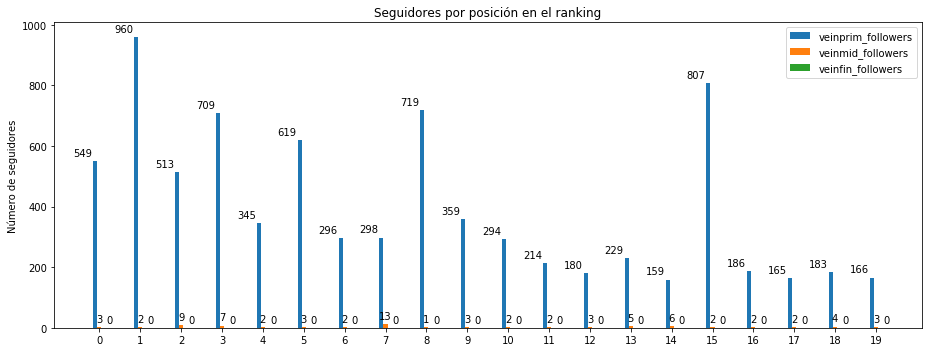

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_followers))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_followers, width,
                label='veinprim_followers')
rects2 = ax.bar(ind, veinmid_followers, width,
                label='veinmid_followers')
rects3 = ax.bar(ind + width, veinfin_followers, width,
                label='veinfin_followers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de seguidores')
ax.set_title('Seguidores por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.show()

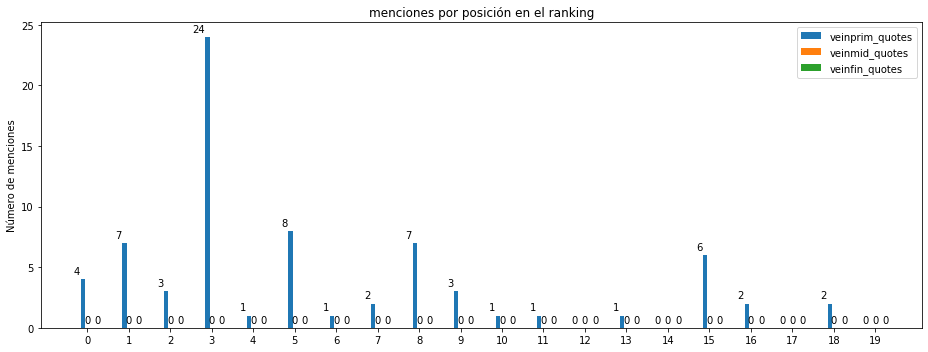

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_quotes))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_quotes, width,
                label='veinprim_quotes')
rects2 = ax.bar(ind, veinmid_quotes, width,
                label='veinmid_quotes')
rects3 = ax.bar(ind + width, veinfin_quotes, width,
                label='veinfin_quotes')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de menciones')
ax.set_title('menciones por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.show()

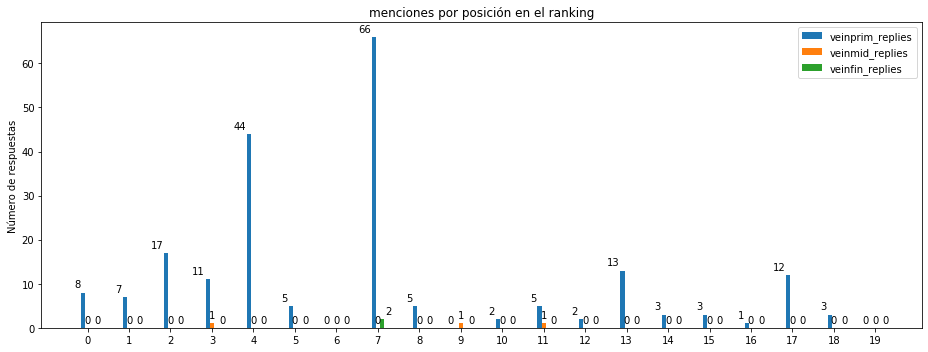

In [81]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_replies))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_replies, width,
                label='veinprim_replies')
rects2 = ax.bar(ind, veinmid_replies, width,
                label='veinmid_replies')
rects3 = ax.bar(ind + width, veinfin_replies, width,
                label='veinfin_replies')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de respuestas')
ax.set_title('respuestas por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.show()

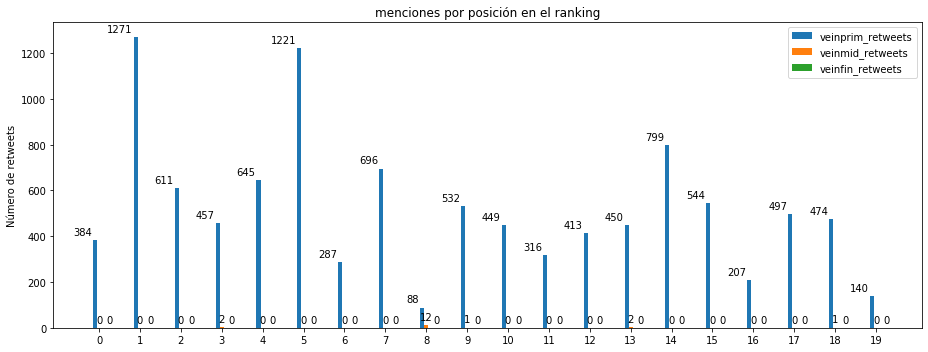

In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_retweets))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_retweets, width,
                label='veinprim_retweets')
rects2 = ax.bar(ind, veinmid_retweets, width,
                label='veinmid_retweets')
rects3 = ax.bar(ind + width, veinfin_retweets, width,
                label='veinfin_retweets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de retweets')
ax.set_title('retweets por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.show()

In [121]:
#A primera vista la diferencia es bastante palpable entre el top y el centro, supongo que si amplio el dataset
#tendremos unos plot más cómodos.

#Ahora vamos a comprobar si alguno de los usuarios que hemos cogido son bots, tomamos como medida para que sean bots
#0.691, basándonos en el estudio de los tutores. De esta forma vamos a ver que puntuación les hemos aplicado
#y sus diferentes valores en cuanto a sus parámetros.

#Cargamos los datos de los usuarios, y tomamos solo un trozo de los datos para no guardarlo todo.

filename = "usuarios.pickle"
idsProbBot = pd.read_pickle(filename)
idsProbBot = idsProbBot.iloc[range(0,20000),]
#Todos los ids de los usuarios de la muestra

In [127]:
idsProbBot = idsProbBot[["_id", "scores_scores_universal"]]

posBots = {}

for index, row in idsProbBot.iterrows():
    
    if row["scores_scores_universal"] >= 0.691:
        
        posBots[row["_id"]] = row["scores_scores_universal"]

In [128]:
len(posBots)

1975

In [131]:
for user in posBots:
    if user in TIFinal:
    
        posBots[user]["TI"] = TIFinal[user]
    

In [135]:
for user in posBots:
    if user in TIFinal:
    
        print(TIFinal[user])
    

In [21]:
#Vamos a crear los archivos txt para introducir dentro del programa gephi

import csv

#Cargamos todos los ids de los usuarios que estamos usando, los relacionamos con sus medidas
filename = "idNodos.pkl"
idNodos = pd.read_pickle(filename)

with open("nodes.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["ID", "NPWTfoco", "NPWTautoridad", "NPWTcentralidad", "TI"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for user in idNodos:
        idstr = str(user)
        thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr]])

In [29]:
#Vamos a crear ahora el archivo txt referente a las aristas
import csv

with open("edgesFoco.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGF:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGF[edge]])

In [30]:
with open("edgesAutoridad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGA:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGA[edge]])

In [31]:
with open("edgesCentralidad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGC:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGC[edge]])

In [23]:
st = '555fc7956cda204928c9dbab'
oid2 = ObjectId(st)
oid2

ObjectId('555fc7956cda204928c9dbab')

In [23]:
st = '(555fc7956cda204928c9dbab,555fc7956cda204928c9dbab)'
st = st.split(",")
st = st[1]
st = st[:-1]
st

'555fc7956cda204928c9dbab'

In [33]:
st = '(555fc7956cda204928c9dbabt,555fc7956cda204928c9dbab)'
st = ((st.split(","))[0])[:-1]
st

'(555fc7956cda204928c9dbab'

In [71]:
usuarios.columns

Index(['_id', 'scores_scores_universal', 'followers', 'friends'], dtype='object')

In [46]:
dic = {"2":22}
"2" in dict

True

In [50]:
dic["3"] = 33

In [51]:
dic

{'2': 22, '3': 33}

In [13]:
followers = {}

for index, row in usuarios.iterrows():
    
    for seguido in row["friends"]:
        
        if (seguido in idsMuestra):
            
            if (seguido in followers):
                
                followers[seguido].append(row["_id"])
            
            else:
                
                followers[seguido] = [row["_id"]]

KeyboardInterrupt: 